# 以相似度为训练目标

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 训练数据生成器

In [2]:
!git clone https://github.com/daibiaoxuwu/328
!git clone https://github.com/daibiaoxuwu/328b


Cloning into '328'...
remote: Enumerating objects: 39999, done.
remote: Counting objects: 100% (39999/39999), done.
remote: Compressing objects: 100% (9914/9914), done.
remote: Total 39999 (delta 30085), reused 39999 (delta 30085), pack-reused 0
Receiving objects: 100% (39999/39999), 23.61 MiB | 26.78 MiB/s, done.
Resolving deltas: 100% (30085/30085), done.
Checking out files: 100% (39997/39997), done.
Cloning into '328b'...
remote: Enumerating objects: 427, done.
remote: Counting objects: 100% (427/427), done.
remote: Compressing objects: 100% (427/427), done.
remote: Total 427 (delta 0), reused 427 (delta 0), pack-reused 0
Receiving objects: 100% (427/427), 3.03 MiB | 7.19 MiB/s, done.


In [0]:
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt

datasizex = 9
datasizey = 9
picnum = 30
lowpercent = 125.0
highpercent = 233.0
enhance = 4
def read_data(path1,path2):

  x_train0 = []
  y_train0 = dict()
  idxes = dict()

  #read clock
  #read and /255
  for filename in os.listdir(path2):
      if 'git' in filename: continue
      ans = cv2.imread(os.path.join(path2,filename),cv2.IMREAD_GRAYSCALE).astype('float32')     
      ans = np.clip((ans-lowpercent)/(highpercent - lowpercent),0,1)
      y_train0[int(filename[:-4])]=ans

  keys = list(y_train0.keys())
  
  #read data
  #add an axis and /255
  
  filelist = os.listdir(path1)
  random.shuffle(filelist)
  index = 0
  for filename in filelist:
      if 'git' in filename or 'c.jpg' in filename: continue
      ##################################
      ##################################
      ##################################
      ##################################
      ##################################
      ftime = int(filename.split('_')[0])
      ##################################
      ##################################
      ##################################
      ##################################
      ##################################
      value = max(filter(lambda t:t<ftime,keys))
      if(abs(ftime-value)<3000):continue

      x_train0.append(cv2.imread(os.path.join(path1,filename)).astype('float32')/255.0)
      if value not in idxes:idxes[value]=[index]
      else: idxes[value].append(index)
      index += 1

  #index data
  print(len(x_train0),index,len(y_train0),len(idxes.keys()))
  lens = [len(i) for i in idxes.values()]
  print(min(lens),max(lens),np.average(lens))
  for key,val in list(idxes.items()):
    if len(val)<picnum:
      idxes.pop(key)
  

  #generator
  def data_generator(ikeys_t):
    picsizex = x_train0[0].shape[0]
    picsizey = x_train0[0].shape[1]
    while True:
      dataout = []
      for i in range(picnum):dataout.append([])
      ansout = []
      for train2 in range(32):
        '''
        while True:
          key = random.choice(ikeys_t)
          idx2 = random.sample(idxes[key],picnum)
          posx = random.randint(0,picsizex-datasizex)
          posy = random.randint(0,picsizey-datasizey)
          pic = x_train0[idx2[i]][posx:posx+datasizex,posy:posy+datasizey,:]
          if(np.sum(pic) < 175):
            for i in range(picnum):
              dataout[i].append(x_train0[idx2[i]][posx:posx+datasizex,posy:posy+datasizey,:])
            ansout.append(y_train0[key][posx:posx+datasizex,posy:posy+datasizey])
            break
        '''
        key = random.choice(ikeys_t)
        idx2 = random.sample(idxes[key],picnum)
        posx = random.randint(0,picsizex-datasizex)
        posy = random.randint(0,picsizey-datasizey)
        pic = x_train0[idx2[i]][posx:posx+datasizex,posy:posy+datasizey,:]
        for i in range(picnum):
          dataout[i].append(x_train0[idx2[i]][posx:posx+datasizex,posy:posy+datasizey,:])
        ansout.append(y_train0[key][posx*enhance:(posx+datasizex)*enhance,posy*enhance:(posy+datasizey)*enhance])
      yield [np.stack(data2) for data2 in dataout],np.stack(ansout)
  def pic_generator(ikeys_t):
    while True:
      key = random.choice(ikeys_t)
      idx2 = random.sample(idxes[key],picnum)
      data=[x_train0[i] for i in idx2]
      ans=y_train0[key]
      yield data,ans

  #split
  ikeys = list(idxes.keys())
  random.shuffle(ikeys)
  ltrain = int(len(ikeys)*0.8)  
  train_generator = data_generator(ikeys[:ltrain])
  test_generator = data_generator(ikeys[ltrain:])
  train_pic_generator = pic_generator(ikeys[:ltrain])
  test_pic_generator = pic_generator(ikeys[ltrain:])

  return train_generator,test_generator,train_pic_generator,test_pic_generator



In [5]:

from matplotlib import pyplot as plt
train_generator,test_generator,train_pic_generator,test_pic_generator = read_data('328','328b')


38005 38005 517 192
156 210 197.94270833333334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


1100.8889
0.0 1.0


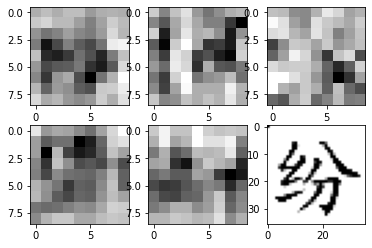

In [6]:
data,ans = next(train_generator)
for pics in data:
  for i in range(6):
    plt.subplot(231+i)
    plt.imshow(pics[i,:,:,0],cmap='gray')
ans[0,0,0]=0
ans[0,1,0]=1
plt.imshow(ans[0],cmap='gray')
print(np.sum(ans[0]))
print(np.min(ans[0]),np.max(ans[0]))

# 数据初始化完成。


# 装载Tensorflow

In [0]:

from __future__ import absolute_import, division, print_function, unicode_literals

# 安装 TensorFlow
try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf


# 搭建模型和训练
现在的网络去掉dropout则可以拟合10张图片，
但是加上dropout就拟合不了。
从7张拟合5张的，则可以在两个epoch（每个epoch抽取60000次）内到80%。

继续训练20张，一个epoch就到60%。

In [0]:
inputs = [tf.keras.layers.Input(shape=(datasizex,datasizey,3))  for i in range(picnum)]
#inputs = tf.keras.layers.Input(shape=(5,12,12,1))
convg1 = 0
convd1 = 0
convh1 = inputs
inputs_big = inputs
for layernum in range(8):
  conv_a1 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
  conva1 = [conv_a1(convh1[i]) for i in range(picnum)]
  #drop_a1 = tf.keras.layers.Dropout(0.2)
  #conva1 = drop_a1(conva1)
  conv_b1 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
  convb1 = [conv_b1(conva1[i]) for i in range(picnum)]
  

  conv_c1 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
  convc1 = [conv_c1(inputs_big[i]) for i in range(picnum)]
  #drop_b1 = tf.keras.layers.Dropout(0.2)
  #convc1 = drop_a1(convc1)
  conv_d1 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
  convd1 = [conv_d1(convc1[i]) for i in range(picnum)]
  

  convs1 = tf.stack(convb1)
  convf1 = [
      tf.math.reduce_max(convs1, axis=[0]),
      tf.math.reduce_mean(convs1, axis=[0]),
      tf.math.reduce_min(convs1, axis=[0]),
  ]

  conv_g1 = tf.keras.layers.Conv2D(32, (3, 3), padding = 'Same',  activation='relu')
  convg1 = [conv_g1(convf1[i]) for i in range(3)]

  drop_c1 = tf.keras.layers.Dropout(0.2)
  convh1 = [drop_c1(tf.concat(convg1+[convd1[i]],axis=3)) for i in range(picnum)]
  if(layernum % 3 == 2):
    convex1 = tf.keras.layers.Conv2D(32, (1, 1), padding = 'Same',  activation='relu')
    convh1 = [tf.keras.layers.UpSampling2D(size=(2, 2), data_format=None)(i) for i in convh1]
    convh1 = [convex1(convh1[i]) for i in range(picnum)]
    inputs_big = [tf.keras.layers.UpSampling2D(size=(2, 2), data_format=None)(i) for i in inputs_big]
convh3 = tf.concat(convg1+convd1,axis=3)

convx1 = tf.keras.layers.Conv2D(64, (3, 3), padding = 'Same',  activation='relu')(convh3)
convx2 = tf.keras.layers.Dropout(0.2)(convx1)
convx3 = tf.keras.layers.Conv2D(64, (3, 3), padding = 'Same', activation='relu')(convx2)
'''
convx3 = tf.keras.layers.Flatten()(convx2)

#keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)
convx4 = tf.keras.layers.Dropout(0.2)(convx3)

convy1 = tf.keras.layers.Dense(21*45)(convx4)
#convy3 = tf.keras.layers.Dense(10,activation='softmax')(convy1)
convy4 = tf.keras.layers.Reshape([21,45])(convy1)
'''

convx4 = tf.keras.layers.Conv2D(1, (3, 3), padding = 'Same')(convx3)

model = tf.keras.Model(inputs=inputs, outputs=convx4)


In [0]:
#tf.reduce_mean(tf.image.ssim(reconstructed, truth, 1.0))
model.compile(optimizer='adam',#tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                #loss=lambda y_pred,y_true:1-tf.reduce_mean(tf.image.ssim_multiscale(tf.clip_by_value(y_pred,0,1), y_true, 255))#-tf.reduce_mean(tf.image.psnr(tf.clip_by_value(y_pred,0,1), y_true, 1.0))
              loss='mse',
              metrics=['mse']
              )
            
#model.summary()

# 测试正确率：

In [0]:
from skimage.metrics import peak_signal_noise_ratio,structural_similarity, mean_squared_error
class show_accuracy(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if epoch % 5 == 1:
      data,ans = next(test_generator)
      data = [data[x][5][np.newaxis,:,:,:] for x in range(picnum)]
      ans = ans[5]
      import matplotlib
      cmap = matplotlib.cm.gray 
      cmap.set_bad(color='black')

      pred = model.predict(data) #shape:(1,11,11,1) because last layer is conv not dense
      #pred = np.clip(pred,0,1)
      #pred = (pred-np.min(pred))/(np.max(pred)-np.min(pred))
      #pred = softmax(pred)
      pred[0,0,0,0]=0
      pred[0,-1,-1,0]=1
      ans[0,0]=0
      ans[-1,-1]=1
      for i in range(6):
        plt.subplot(231+i)
        plt.imshow(data[i][0,:,:,0],cmap=cmap)
      plt.show()
      plt.subplot(121)
      plt.imshow(pred[0,:,:,0],cmap=cmap)
      plt.colorbar()
      #ans = np.clip((ans-np.percentile(ans,10))/(np.percentile(ans,90)-np.percentile(ans,10)),0,1)
      plt.subplot(122)
      plt.imshow(ans,cmap=cmap)
      plt.colorbar()
      plt.show()
#      print('psnr',peak_signal_noise_ratio(np.clip(pred[0,:,:,0],0,1),ans))
#      print('ssim',structural_similarity(np.clip(pred[0,:,:,0],0,1),ans))
      print('mse',mean_squared_error(np.clip(pred[0,:,:,0],0,1),ans))



# 开始训练

In [0]:
# Suppress some level of logs
import logging
logging.getLogger("tensorflow").setLevel(logging.WARN)

In [12]:
ckpt_filename = tf.train.latest_checkpoint("/content/drive/My Drive/checkpoints/training_41")
print(ckpt_filename)
model.load_weights(ckpt_filename)#,by_name=True)

/content/drive/My Drive/checkpoints/training_41/cp-48-0.0779.ckpt


In [0]:
checkpoint_path = "/content/drive/My Drive/checkpoints/training_42/cp-{epoch:02d}-{val_loss:.4f}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=True,monitor='val_loss')#,save_best_only=True,mode='min')
show_accuracy_callback = show_accuracy()

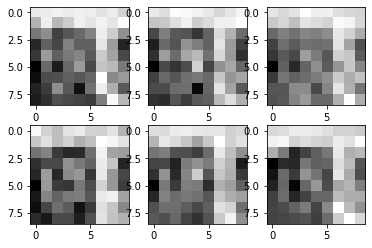

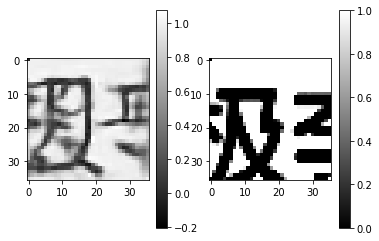

mse 0.26885873398738747


In [14]:
show_accuracy_callback.on_epoch_end(epoch=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
500/500 - 272s - loss: 0.0743 - mse: 0.0743 - val_loss: 0.0694 - val_mse: 0.0694
Epoch 2/200


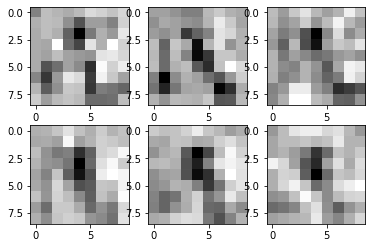

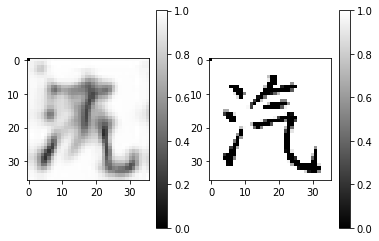

mse 0.06216311123447319
500/500 - 264s - loss: 0.0671 - mse: 0.0671 - val_loss: 0.0682 - val_mse: 0.0682
Epoch 3/200
500/500 - 262s - loss: 0.0637 - mse: 0.0637 - val_loss: 0.0677 - val_mse: 0.0677
Epoch 4/200
500/500 - 262s - loss: 0.0611 - mse: 0.0611 - val_loss: 0.0693 - val_mse: 0.0693
Epoch 5/200
500/500 - 263s - loss: 0.0594 - mse: 0.0594 - val_loss: 0.0685 - val_mse: 0.0685
Epoch 6/200
500/500 - 262s - loss: 0.0575 - mse: 0.0575 - val_loss: 0.0690 - val_mse: 0.0690
Epoch 7/200


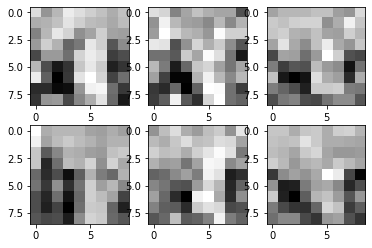

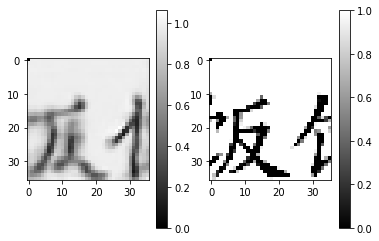

mse 0.07224437648260705
500/500 - 263s - loss: 0.0561 - mse: 0.0561 - val_loss: 0.0682 - val_mse: 0.0682
Epoch 8/200
500/500 - 262s - loss: 0.0549 - mse: 0.0549 - val_loss: 0.0692 - val_mse: 0.0692
Epoch 9/200
500/500 - 262s - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0695 - val_mse: 0.0695
Epoch 10/200
500/500 - 262s - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0699 - val_mse: 0.0699
Epoch 11/200
500/500 - 262s - loss: 0.0519 - mse: 0.0519 - val_loss: 0.0689 - val_mse: 0.0689
Epoch 12/200


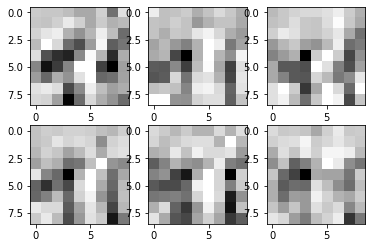

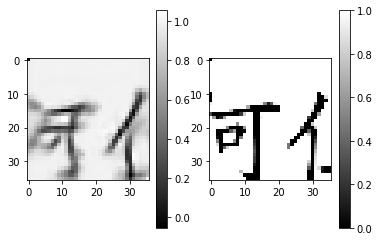

mse 0.057641469309754924
500/500 - 264s - loss: 0.0510 - mse: 0.0510 - val_loss: 0.0684 - val_mse: 0.0684
Epoch 13/200
500/500 - 262s - loss: 0.0502 - mse: 0.0502 - val_loss: 0.0705 - val_mse: 0.0705
Epoch 14/200
500/500 - 261s - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0710 - val_mse: 0.0710
Epoch 15/200
500/500 - 261s - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0708 - val_mse: 0.0708
Epoch 16/200
500/500 - 261s - loss: 0.0484 - mse: 0.0484 - val_loss: 0.0707 - val_mse: 0.0707
Epoch 17/200


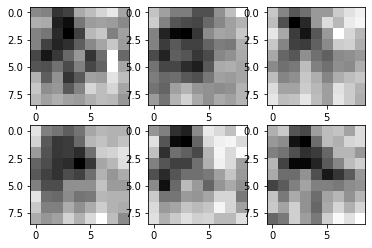

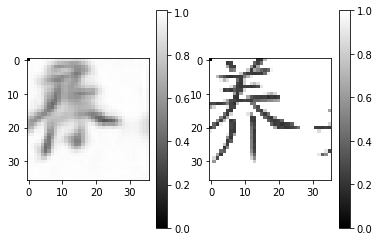

mse 0.04524310927513877
500/500 - 262s - loss: 0.0477 - mse: 0.0477 - val_loss: 0.0712 - val_mse: 0.0712
Epoch 18/200
500/500 - 261s - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0700 - val_mse: 0.0700
Epoch 19/200
500/500 - 261s - loss: 0.0470 - mse: 0.0470 - val_loss: 0.0714 - val_mse: 0.0714
Epoch 20/200
500/500 - 261s - loss: 0.0466 - mse: 0.0466 - val_loss: 0.0707 - val_mse: 0.0707
Epoch 21/200
500/500 - 261s - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0717 - val_mse: 0.0717
Epoch 22/200


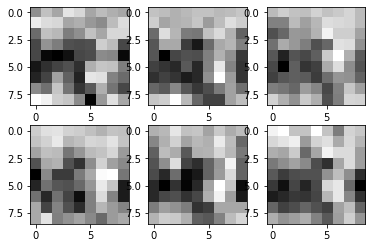

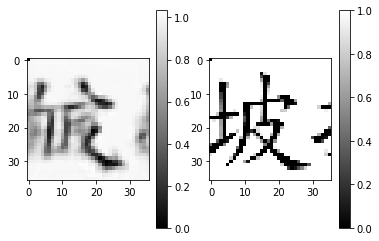

mse 0.08608867863017369
500/500 - 262s - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0697 - val_mse: 0.0697
Epoch 23/200
500/500 - 261s - loss: 0.0454 - mse: 0.0454 - val_loss: 0.0710 - val_mse: 0.0710
Epoch 24/200
500/500 - 261s - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0709 - val_mse: 0.0709
Epoch 25/200
500/500 - 261s - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0721 - val_mse: 0.0721
Epoch 26/200
500/500 - 261s - loss: 0.0446 - mse: 0.0446 - val_loss: 0.0715 - val_mse: 0.0715
Epoch 27/200


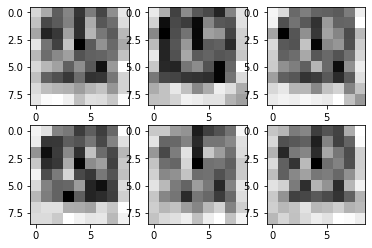

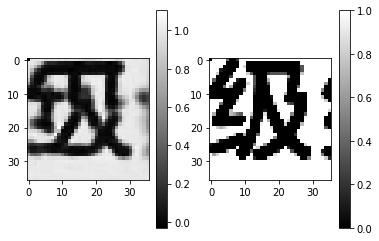

mse 0.10865437433646315
500/500 - 262s - loss: 0.0444 - mse: 0.0444 - val_loss: 0.0711 - val_mse: 0.0711
Epoch 28/200
500/500 - 261s - loss: 0.0440 - mse: 0.0440 - val_loss: 0.0718 - val_mse: 0.0718
Epoch 29/200
500/500 - 260s - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0725 - val_mse: 0.0725
Epoch 30/200
500/500 - 260s - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0719 - val_mse: 0.0719
Epoch 31/200
500/500 - 261s - loss: 0.0434 - mse: 0.0434 - val_loss: 0.0720 - val_mse: 0.0720
Epoch 32/200


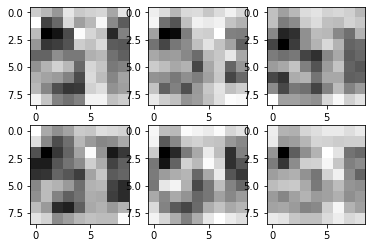

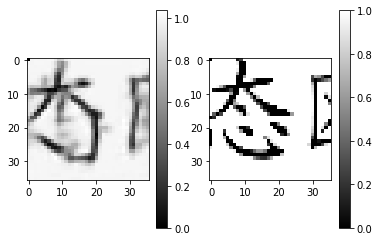

mse 0.07227290611877517
500/500 - 261s - loss: 0.0430 - mse: 0.0430 - val_loss: 0.0724 - val_mse: 0.0724
Epoch 33/200
500/500 - 260s - loss: 0.0426 - mse: 0.0426 - val_loss: 0.0722 - val_mse: 0.0722
Epoch 34/200
500/500 - 260s - loss: 0.0430 - mse: 0.0430 - val_loss: 0.0717 - val_mse: 0.0717
Epoch 35/200
500/500 - 259s - loss: 0.0425 - mse: 0.0425 - val_loss: 0.0734 - val_mse: 0.0734
Epoch 36/200
500/500 - 260s - loss: 0.0422 - mse: 0.0422 - val_loss: 0.0731 - val_mse: 0.0731
Epoch 37/200


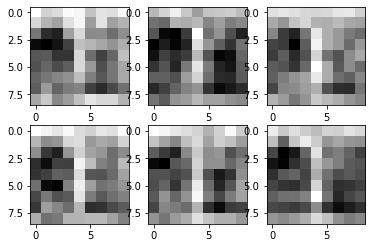

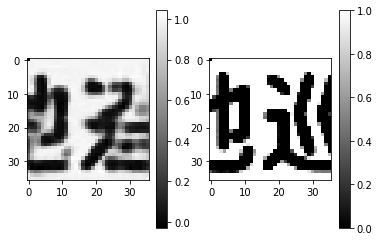

mse 0.13753670672412713
500/500 - 261s - loss: 0.0421 - mse: 0.0421 - val_loss: 0.0714 - val_mse: 0.0714
Epoch 38/200
500/500 - 260s - loss: 0.0418 - mse: 0.0418 - val_loss: 0.0715 - val_mse: 0.0715
Epoch 39/200
500/500 - 260s - loss: 0.0418 - mse: 0.0418 - val_loss: 0.0726 - val_mse: 0.0726
Epoch 40/200
500/500 - 261s - loss: 0.0414 - mse: 0.0414 - val_loss: 0.0735 - val_mse: 0.0735
Epoch 41/200
500/500 - 262s - loss: 0.0415 - mse: 0.0415 - val_loss: 0.0738 - val_mse: 0.0738
Epoch 42/200


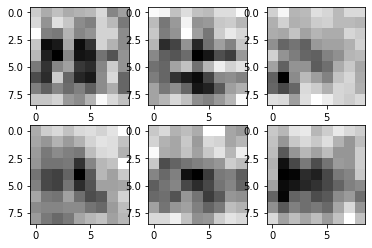

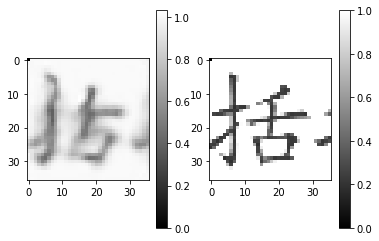

mse 0.03883998492409565
500/500 - 263s - loss: 0.0413 - mse: 0.0413 - val_loss: 0.0732 - val_mse: 0.0732
Epoch 43/200
500/500 - 260s - loss: 0.0409 - mse: 0.0409 - val_loss: 0.0730 - val_mse: 0.0730
Epoch 44/200
500/500 - 260s - loss: 0.0409 - mse: 0.0409 - val_loss: 0.0732 - val_mse: 0.0732
Epoch 45/200
500/500 - 260s - loss: 0.0408 - mse: 0.0408 - val_loss: 0.0734 - val_mse: 0.0734
Epoch 46/200
500/500 - 261s - loss: 0.0405 - mse: 0.0405 - val_loss: 0.0721 - val_mse: 0.0721
Epoch 47/200


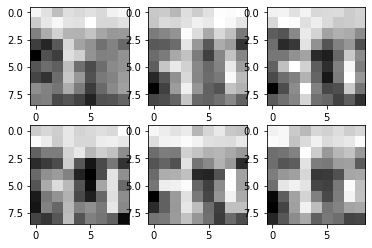

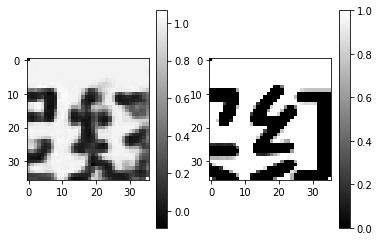

mse 0.10100361016728458
500/500 - 261s - loss: 0.0404 - mse: 0.0404 - val_loss: 0.0730 - val_mse: 0.0730
Epoch 48/200
500/500 - 260s - loss: 0.0404 - mse: 0.0404 - val_loss: 0.0738 - val_mse: 0.0738
Epoch 49/200
500/500 - 260s - loss: 0.0403 - mse: 0.0403 - val_loss: 0.0745 - val_mse: 0.0745
Epoch 50/200
500/500 - 260s - loss: 0.0401 - mse: 0.0401 - val_loss: 0.0733 - val_mse: 0.0733
Epoch 51/200
500/500 - 260s - loss: 0.0399 - mse: 0.0399 - val_loss: 0.0745 - val_mse: 0.0745
Epoch 52/200


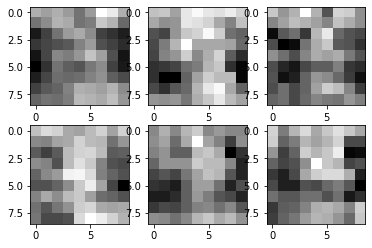

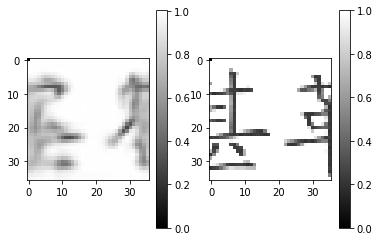

mse 0.0546034912236891
500/500 - 260s - loss: 0.0398 - mse: 0.0398 - val_loss: 0.0728 - val_mse: 0.0728
Epoch 53/200
500/500 - 260s - loss: 0.0398 - mse: 0.0398 - val_loss: 0.0737 - val_mse: 0.0737
Epoch 54/200
500/500 - 260s - loss: 0.0398 - mse: 0.0398 - val_loss: 0.0751 - val_mse: 0.0751
Epoch 55/200
500/500 - 260s - loss: 0.0392 - mse: 0.0392 - val_loss: 0.0737 - val_mse: 0.0737
Epoch 56/200
500/500 - 260s - loss: 0.0396 - mse: 0.0396 - val_loss: 0.0742 - val_mse: 0.0742
Epoch 57/200


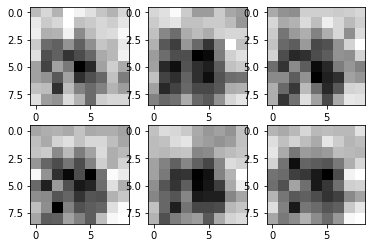

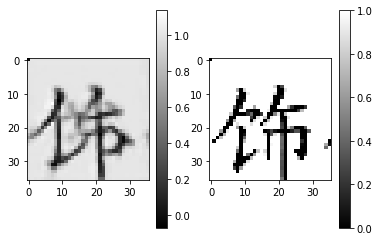

mse 0.05817946627916792
500/500 - 261s - loss: 0.0392 - mse: 0.0392 - val_loss: 0.0743 - val_mse: 0.0743
Epoch 58/200
500/500 - 260s - loss: 0.0394 - mse: 0.0394 - val_loss: 0.0754 - val_mse: 0.0754
Epoch 59/200
500/500 - 261s - loss: 0.0390 - mse: 0.0390 - val_loss: 0.0734 - val_mse: 0.0734
Epoch 60/200
500/500 - 261s - loss: 0.0389 - mse: 0.0389 - val_loss: 0.0738 - val_mse: 0.0738
Epoch 61/200
500/500 - 260s - loss: 0.0388 - mse: 0.0388 - val_loss: 0.0742 - val_mse: 0.0742
Epoch 62/200


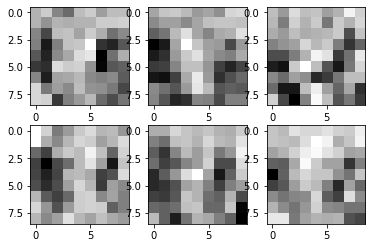

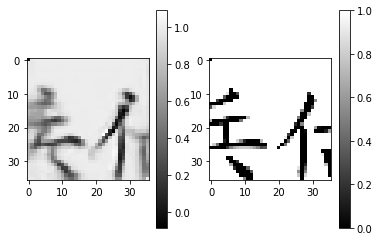

mse 0.055980344499132
500/500 - 261s - loss: 0.0385 - mse: 0.0385 - val_loss: 0.0737 - val_mse: 0.0737
Epoch 63/200
500/500 - 260s - loss: 0.0388 - mse: 0.0388 - val_loss: 0.0742 - val_mse: 0.0742
Epoch 64/200
500/500 - 260s - loss: 0.0385 - mse: 0.0385 - val_loss: 0.0752 - val_mse: 0.0752
Epoch 65/200
500/500 - 260s - loss: 0.0387 - mse: 0.0387 - val_loss: 0.0731 - val_mse: 0.0731
Epoch 66/200
500/500 - 260s - loss: 0.0385 - mse: 0.0385 - val_loss: 0.0742 - val_mse: 0.0742
Epoch 67/200


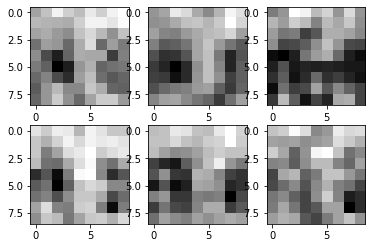

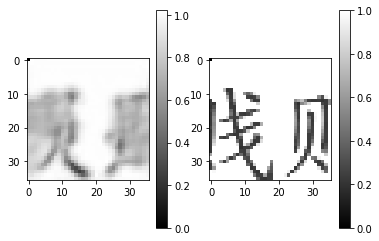

mse 0.05349685159362005
500/500 - 261s - loss: 0.0385 - mse: 0.0385 - val_loss: 0.0748 - val_mse: 0.0748
Epoch 68/200
500/500 - 260s - loss: 0.0380 - mse: 0.0380 - val_loss: 0.0742 - val_mse: 0.0742
Epoch 69/200
500/500 - 260s - loss: 0.0381 - mse: 0.0381 - val_loss: 0.0748 - val_mse: 0.0748
Epoch 70/200
500/500 - 260s - loss: 0.0381 - mse: 0.0381 - val_loss: 0.0744 - val_mse: 0.0744
Epoch 71/200
500/500 - 260s - loss: 0.0380 - mse: 0.0380 - val_loss: 0.0749 - val_mse: 0.0749
Epoch 72/200


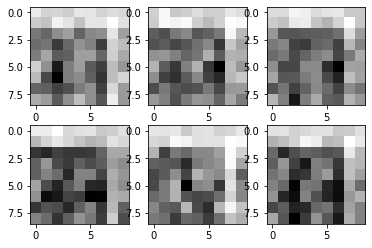

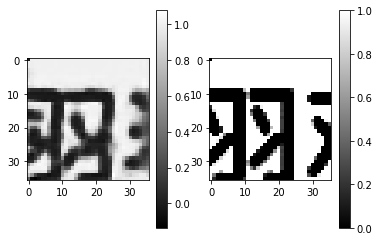

mse 0.08985294728231243
500/500 - 261s - loss: 0.0379 - mse: 0.0379 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 73/200
500/500 - 261s - loss: 0.0379 - mse: 0.0379 - val_loss: 0.0733 - val_mse: 0.0733
Epoch 74/200
500/500 - 261s - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0744 - val_mse: 0.0744
Epoch 75/200
500/500 - 261s - loss: 0.0376 - mse: 0.0376 - val_loss: 0.0740 - val_mse: 0.0740
Epoch 76/200
500/500 - 261s - loss: 0.0376 - mse: 0.0376 - val_loss: 0.0736 - val_mse: 0.0736
Epoch 77/200


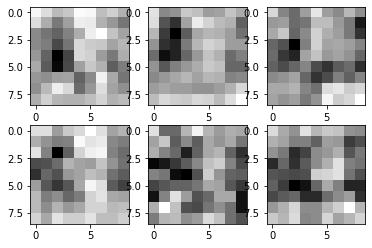

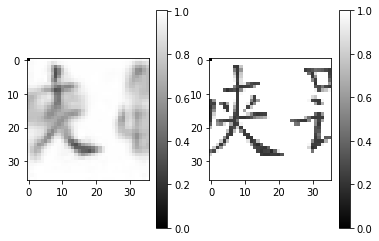

mse 0.03932856126339065
500/500 - 262s - loss: 0.0375 - mse: 0.0375 - val_loss: 0.0748 - val_mse: 0.0748
Epoch 78/200
500/500 - 260s - loss: 0.0374 - mse: 0.0374 - val_loss: 0.0751 - val_mse: 0.0751
Epoch 79/200
500/500 - 260s - loss: 0.0374 - mse: 0.0374 - val_loss: 0.0743 - val_mse: 0.0743
Epoch 80/200
500/500 - 260s - loss: 0.0375 - mse: 0.0375 - val_loss: 0.0747 - val_mse: 0.0747
Epoch 81/200
500/500 - 261s - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0735 - val_mse: 0.0735
Epoch 82/200


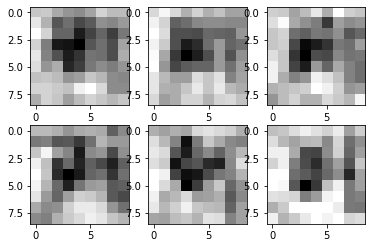

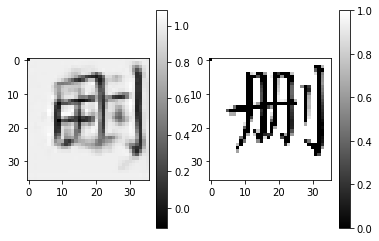

mse 0.12723302673859072
500/500 - 261s - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0749 - val_mse: 0.0749
Epoch 83/200
500/500 - 260s - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0740 - val_mse: 0.0740
Epoch 84/200
500/500 - 260s - loss: 0.0370 - mse: 0.0370 - val_loss: 0.0736 - val_mse: 0.0736
Epoch 85/200
500/500 - 260s - loss: 0.0373 - mse: 0.0373 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 86/200
500/500 - 261s - loss: 0.0371 - mse: 0.0371 - val_loss: 0.0741 - val_mse: 0.0741
Epoch 87/200


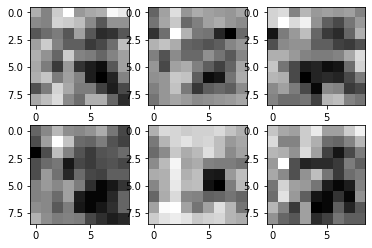

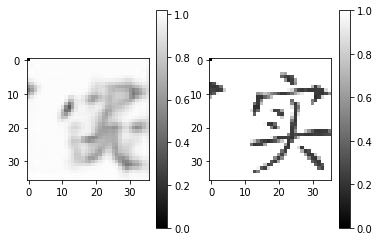

mse 0.04450272193326925
500/500 - 263s - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0747 - val_mse: 0.0747
Epoch 88/200
500/500 - 261s - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 89/200
500/500 - 260s - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0750 - val_mse: 0.0750
Epoch 90/200
500/500 - 261s - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0749 - val_mse: 0.0749
Epoch 91/200
500/500 - 260s - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0750 - val_mse: 0.0750
Epoch 92/200


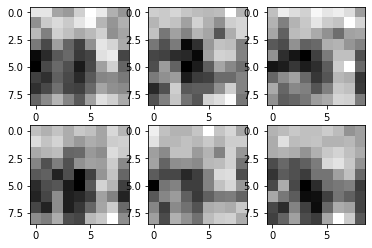

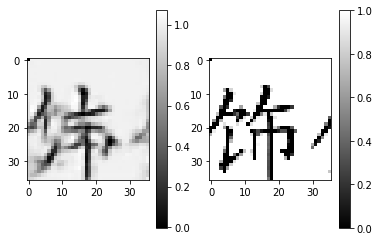

mse 0.07053347724838774
500/500 - 261s - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 93/200
500/500 - 262s - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0742 - val_mse: 0.0742
Epoch 94/200
500/500 - 262s - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 95/200
500/500 - 261s - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0747 - val_mse: 0.0747
Epoch 96/200
500/500 - 260s - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0749 - val_mse: 0.0749
Epoch 97/200


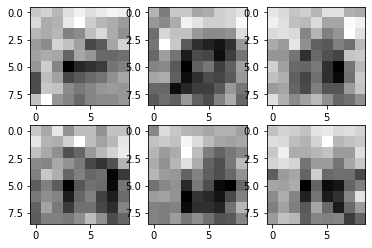

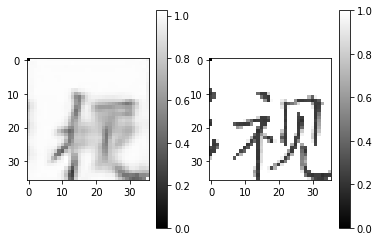

mse 0.05205508463289751
500/500 - 261s - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0749 - val_mse: 0.0749
Epoch 98/200
500/500 - 261s - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0754 - val_mse: 0.0754
Epoch 99/200
500/500 - 262s - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0748 - val_mse: 0.0748
Epoch 100/200
500/500 - 262s - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0758 - val_mse: 0.0758
Epoch 101/200
500/500 - 261s - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0742 - val_mse: 0.0742
Epoch 102/200


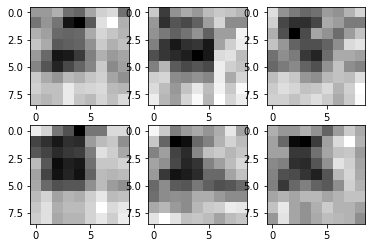

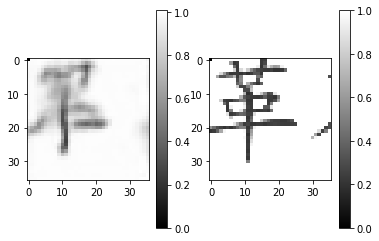

mse 0.03911162902683718
500/500 - 262s - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 103/200
500/500 - 260s - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0755 - val_mse: 0.0755
Epoch 104/200
500/500 - 260s - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0746 - val_mse: 0.0746
Epoch 105/200
500/500 - 260s - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0780 - val_mse: 0.0780
Epoch 106/200
500/500 - 260s - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0755 - val_mse: 0.0755
Epoch 107/200


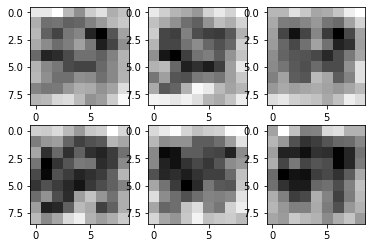

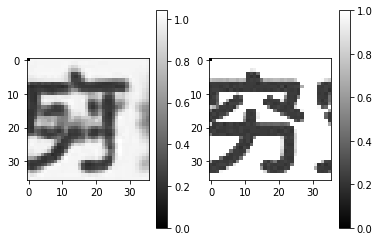

mse 0.06313109760760224
500/500 - 261s - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 108/200
500/500 - 260s - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0749 - val_mse: 0.0749
Epoch 109/200
500/500 - 260s - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0751 - val_mse: 0.0751
Epoch 110/200
500/500 - 260s - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 111/200
500/500 - 260s - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0753 - val_mse: 0.0753
Epoch 112/200


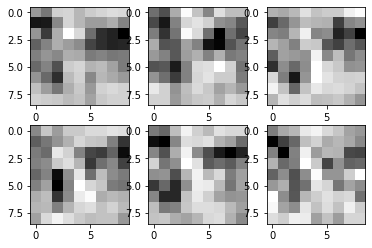

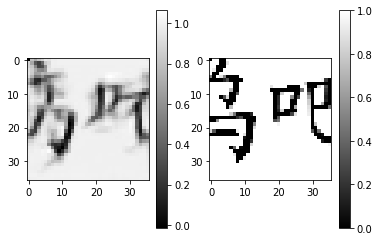

mse 0.10128159617027364
500/500 - 261s - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0747 - val_mse: 0.0747
Epoch 113/200
500/500 - 260s - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 114/200
500/500 - 260s - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0743 - val_mse: 0.0743
Epoch 115/200
500/500 - 260s - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 116/200


KeyboardInterrupt: ignored

In [15]:
if True:
  if not os.path.exists(checkpoint_dir):
    model.fit_generator(train_generator,epochs=200,steps_per_epoch=500,validation_data=test_generator,validation_steps=50,validation_freq=1,verbose=2,callbacks=[cp_callback,show_accuracy_callback])


# 验证模型

In [0]:
def predict_pic(xpics,model):
  # xpic: array of 5 with size(22,52,1)
  picsizex = xpics[0].shape[0]
  picsizey = xpics[0].shape[1]
  picout = np.zeros((picsizex*enhance,picsizey*enhance),dtype=np.float32)
  piclayer = np.zeros((picsizex*enhance,picsizey*enhance),dtype=int)
  for posx in range(0,picsizex+1-datasizex):
    for posy in range(0,picsizey+1-datasizey):
      dataout = [pic[np.newaxis,posx:posx+datasizex,posy:posy+datasizey,:] for pic in xpics]
      pred = model.predict(dataout)
      picout[posx*enhance:(posx+datasizex)*enhance,posy*enhance:(posy+datasizey)*enhance] += pred[0,:,:,0]
      piclayer[posx*enhance:(posx+datasizex)*enhance,posy*enhance:(posy+datasizey)*enhance] += np.ones((datasizex*enhance,datasizey*enhance),dtype=int)
  picout /= piclayer
  return picout


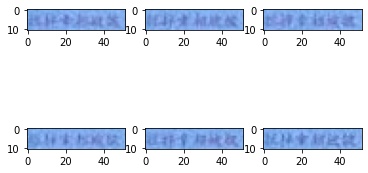

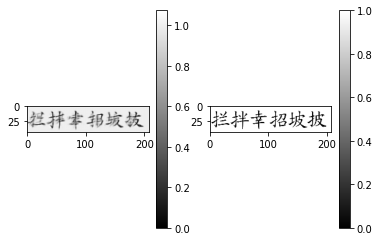

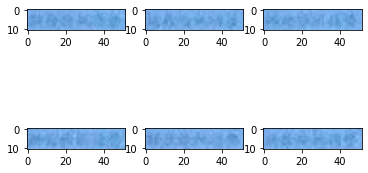

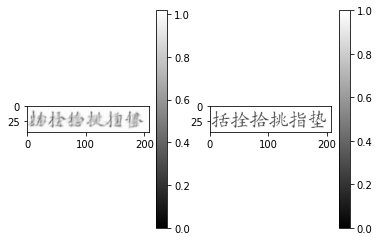

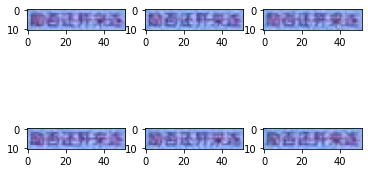

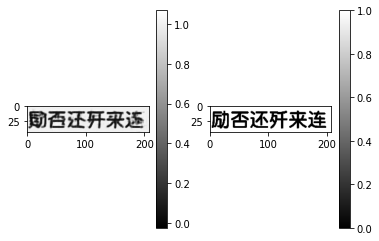

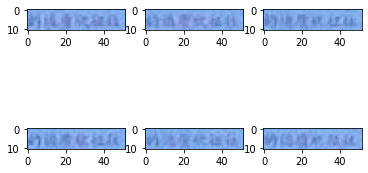

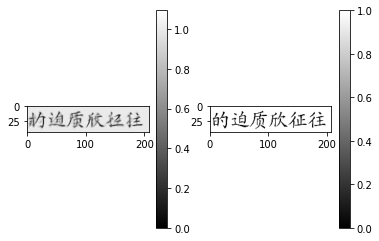

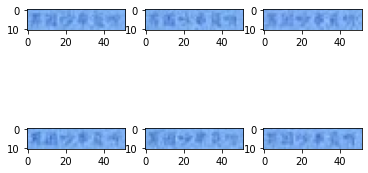

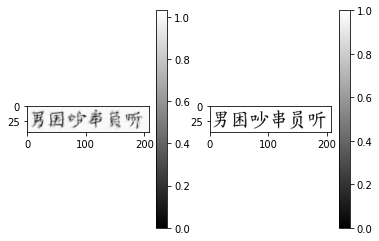

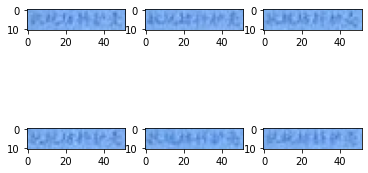

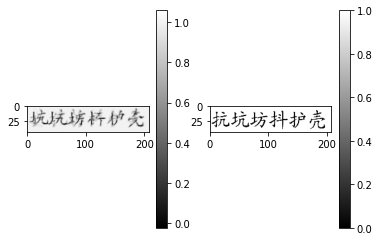

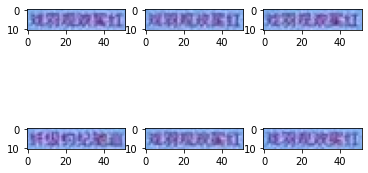

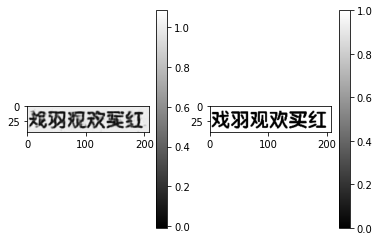

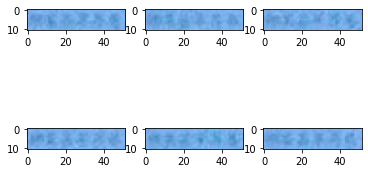

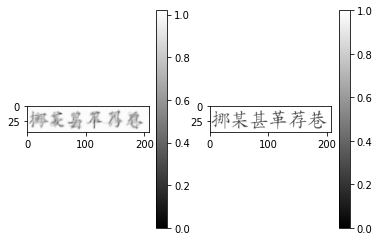

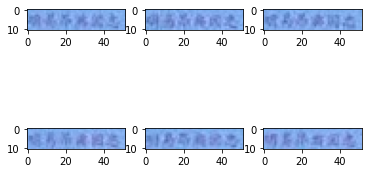

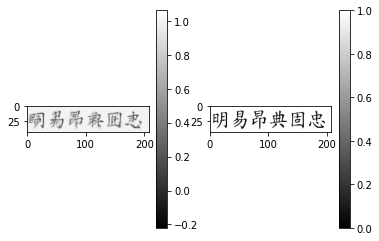

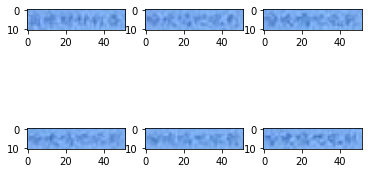

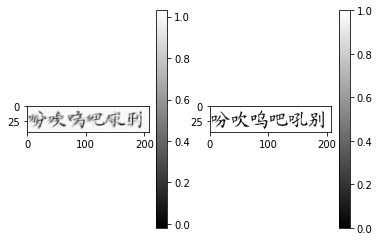

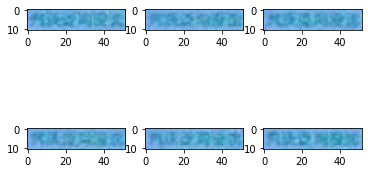

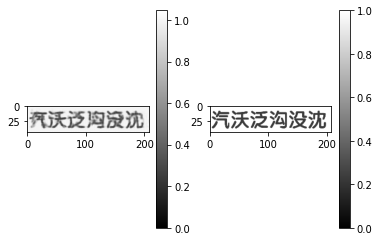

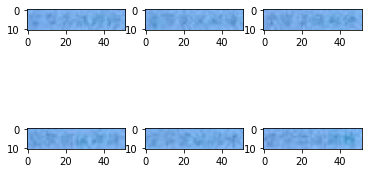

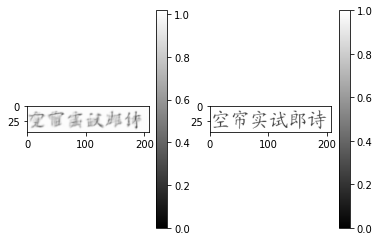

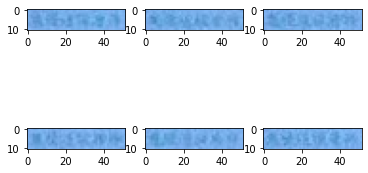

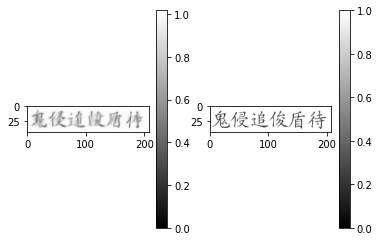

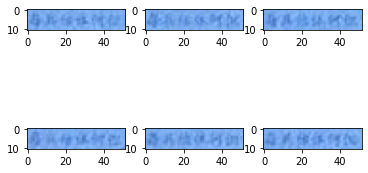

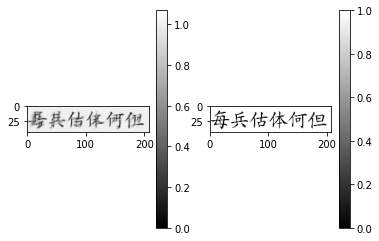

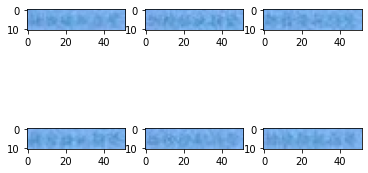

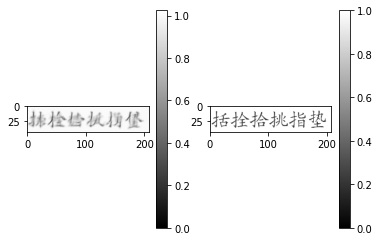

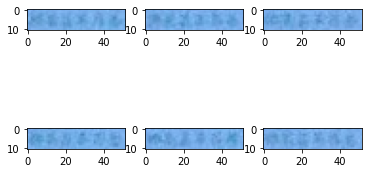

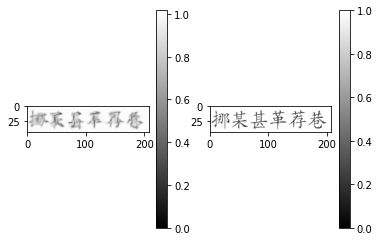

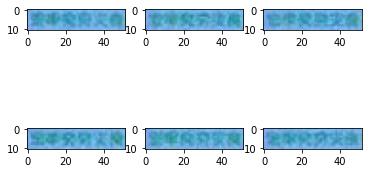

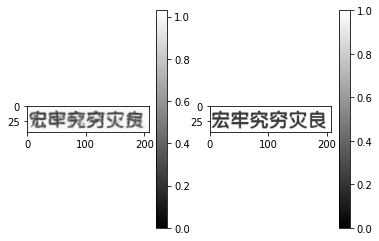

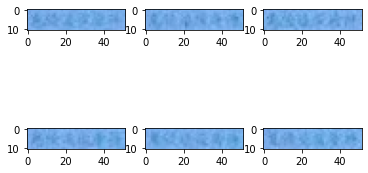

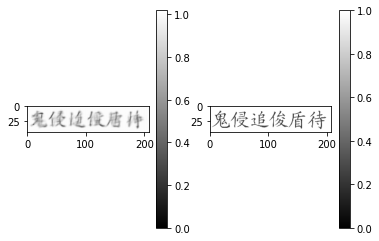

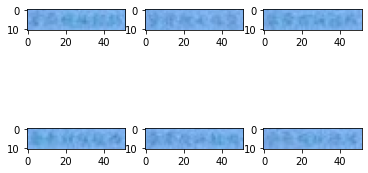

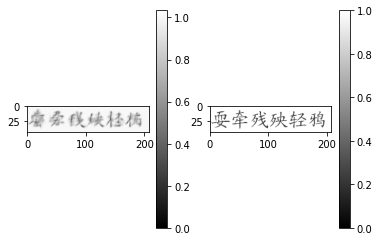

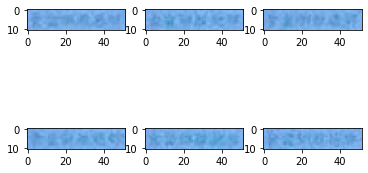

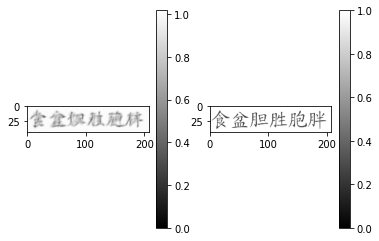

In [17]:
for t in range(20):
  data,ans = next(test_pic_generator)

  import matplotlib
  cmap = matplotlib.cm.gray 
  cmap.set_bad(color='black')

  pred = predict_pic(data,model)

  for i in range(6):
    plt.subplot(231+i)
    b,g,r = cv2.split(data[i])       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)

  plt.show()      
  pred[0,0]=0
  pred[-1,-1]=1
  ans[0,0]=0
  ans[-1,-1]=1
  plt.subplot(121)
  plt.imshow(pred,cmap=cmap)
  plt.colorbar()
  #ans = np.clip((ans-np.percentile(ans,10))/(np.percentile(ans,90)-np.percentile(ans,10)),0,1)
  plt.subplot(122)
  plt.imshow(ans,cmap=cmap)
  plt.colorbar()
  plt.show()
  #      print('psnr',peak_signal_noise_ratio(np.clip(pred[0,:,:,0],0,1),ans))
  #      print('ssim',structural_similarity(np.clip(pred[0,:,:,0],0,1),ans))
  #print('mse',mean_squared_error(np.clip(pred,0,1),ans))
